In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
import sys
sys.path.insert(0, '../../../rb_utils/')
sys.path.insert(0, '../../rb_utils/')
import common_utils 

# Load data

In [15]:
train_set = mnist_data_utils.MovingMNISTDataSet(data_dir = './mnist_data/',
                        indices = np.load('./train_indx.npy'),
                        train_set = True)


In [16]:
train_set.sample_indx

array([24740, 34509, 39894, ..., 13692, 50687, 24189])

In [17]:
len(train_set)

6000

In [18]:
train_set.num_images

6000

In [3]:
data_dir = './mnist_data/'
propn_sample = 0.001

In [4]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [5]:
batchsize = 12

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [6]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [7]:
slen = data_train['image'].shape[-1]

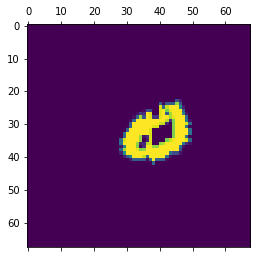

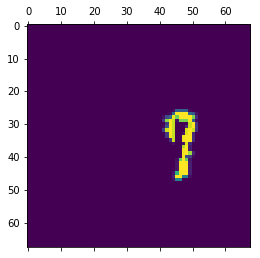

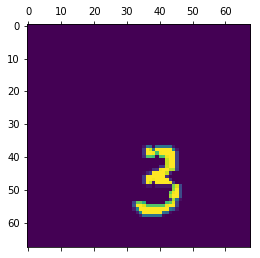

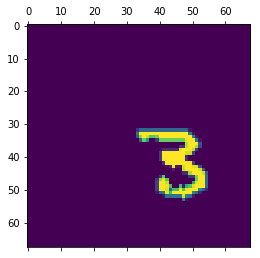

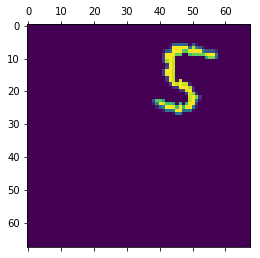

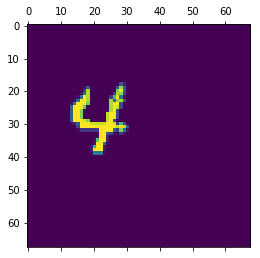

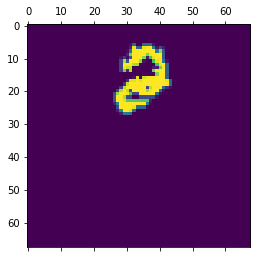

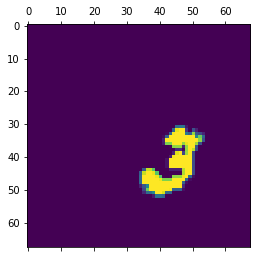

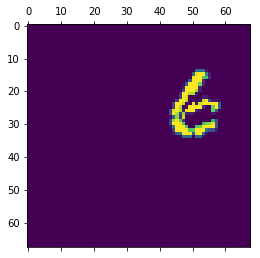

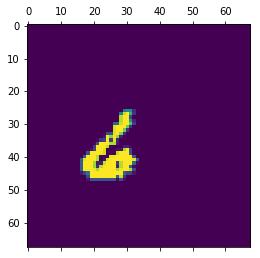

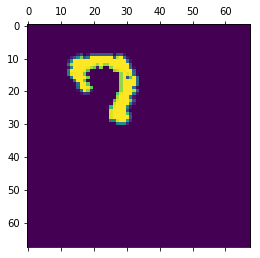

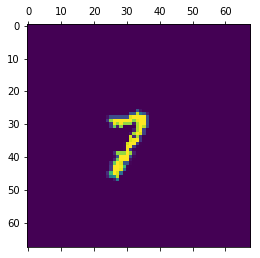

In [8]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

In [9]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

# Define VAE

In [10]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [11]:
# Check padding and cropping functions

In [12]:
full_slen = image.shape[-1]

pixel_1d = pixel_2d[:, 1] * 68 + pixel_2d[:, 0]

one_hot_pixel = common_utils.get_one_hot_encoding_from_int(pixel_1d, full_slen**2)

In [13]:

cropped_images = moving_mnist_vae.crop_image(one_hot_pixel, image)

In [14]:
repadded_images = moving_mnist_vae.pad_image(cropped_images, one_hot_pixel)

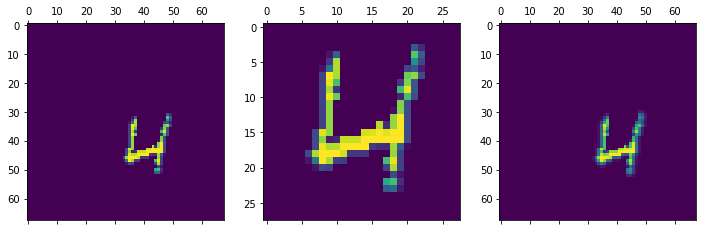

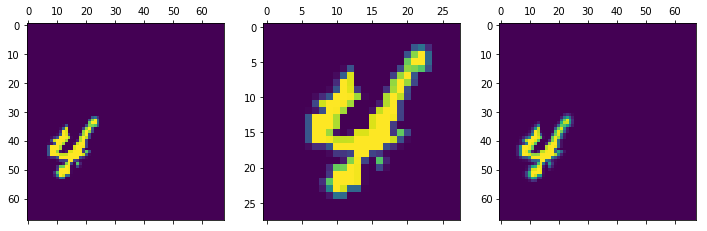

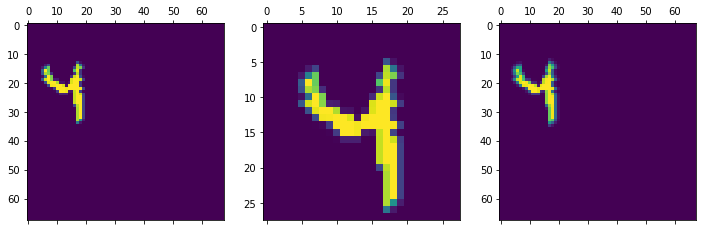

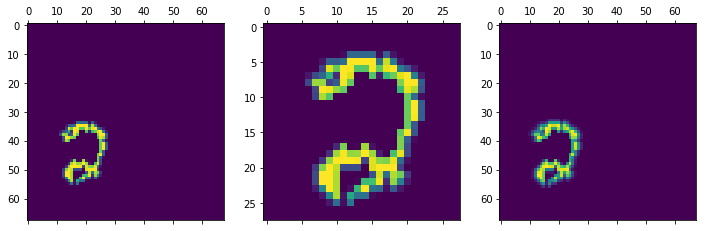

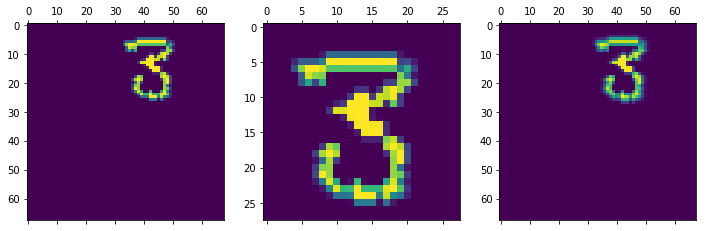

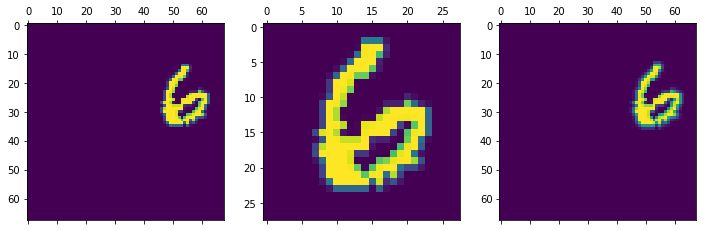

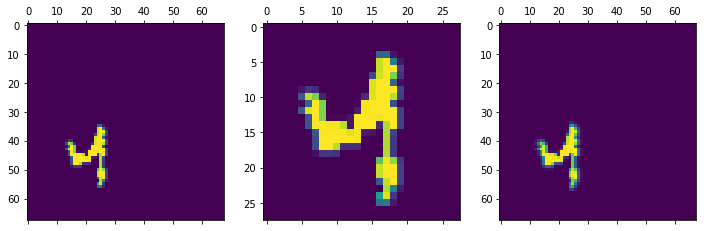

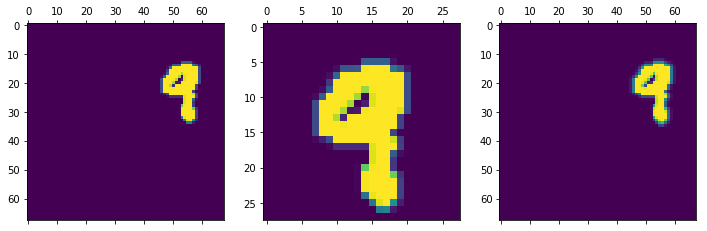

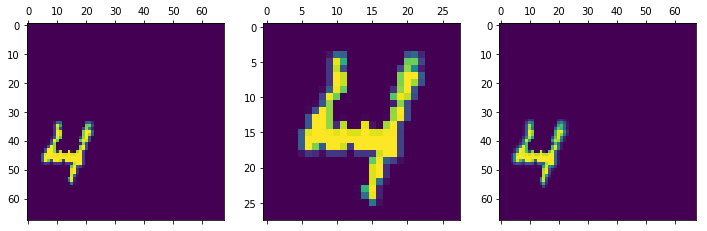

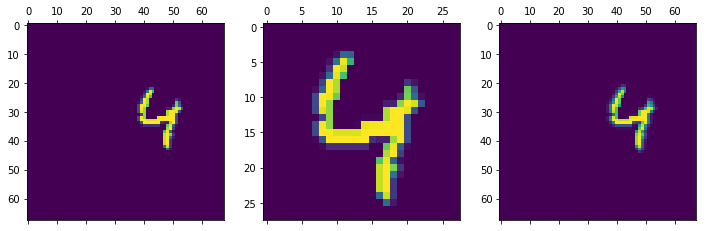

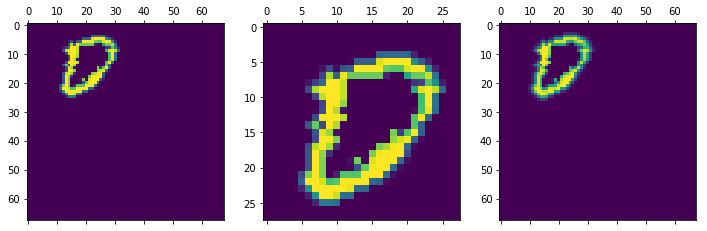

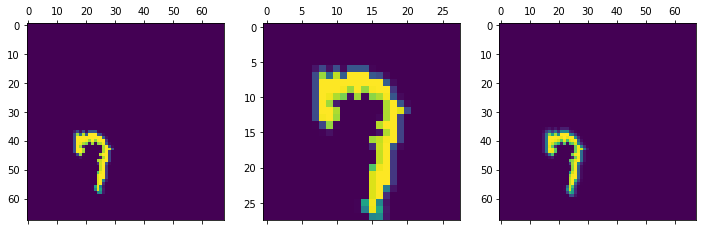

In [15]:
for i in range(batchsize): 
        
    _, axarr = plt.subplots(1, 3, figsize=(12, 12))
    
    axarr[0].matshow(image[i, 0, :, :])
    axarr[1].matshow(cropped_images[i, 0, :, :])
    axarr[2].matshow(repadded_images[i, 0, :, :])

In [16]:
image.shape

torch.Size([12, 1, 68, 68])

In [17]:
cropped_images.shape

torch.Size([12, 1, 28, 28])

In [18]:
repadded_images.shape

torch.Size([12, 1, 68, 68])

# Check training goes through

In [19]:
import baselines_lib as bs_lib

In [20]:
weight_decay = 1e-6
lr = 0.001

optimizer = optim.Adam([
                {'params': moving_mnist_vae.parameters(),
                'lr': lr,
                'weight_decay': weight_decay}])

grad_estimator = bs_lib.reinforce

In [21]:
moving_mnist_vae.get_rb_loss(image,
                        grad_estimator,
                        grad_estimator_kwargs = {'grad_estimator_kwargs': None},
                        epoch = None,
                        topk = 0,
                        n_samples = 1,
                        true_pixel_2d = None)

(tensor(1.00000e+05 *
        -2.0475), tensor(25087.3105))

In [23]:
vae_training_lib.eval_vae(moving_mnist_vae, train_loader, \
                grad_estimator,
                grad_estimator_kwargs = {'grad_estimator_kwargs': None},
                optimizer = None,
                train = False,
                set_true_loc = False,
                topk = 0,
                n_samples = 1,
                epoch = 0)

tensor(2274.2529)

In [24]:
vae_training_lib.train_vae(moving_mnist_vae, train_loader, test_loader, optimizer, grad_estimator, 
                outfile = './mnist_vae_results/test',
                n_epoch = 5, print_every = 2, save_every = 2, topk = 5,
                set_true_loc = True)

  * init train recon loss: 579.1174316;
  * init test recon loss: 578.1175537;
  * debugging_images loss: 2442.989746;
writing the parameters to ./mnist_vae_results/test_epoch0

[1] unlabeled_loss: 545.8178101  	[7.6 seconds]
[2] unlabeled_loss: 436.1414185  	[7.5 seconds]
  * train recon loss: 367.2864075;
  * test recon loss: 368.1025696;
  * debugging_images loss: 2361.044189;
writing the parameters to ./mnist_vae_results/test_epoch2

[3] unlabeled_loss: 335.7331543  	[7.6 seconds]
[4] unlabeled_loss: 283.399353  	[7.7 seconds]
  * train recon loss: 267.1393738;
  * test recon loss: 268.9250793;
  * debugging_images loss: 2333.734131;
writing the parameters to ./mnist_vae_results/test_epoch4

[5] unlabeled_loss: 260.4355774  	[7.8 seconds]
writing the parameters to ./mnist_vae_results/test_final



In [25]:
np.load('./mnist_vae_results/test_test_losses.npy')

array([578.11755, 368.10257, 268.92508], dtype=float32)